# Analysis of Monthly Mean Meteorologic Future Variables from LOCA and BCSD

This notebook analyzes hydrologic variables from the historical (1950-2005) and RCP (2006-2100) scenarios from the LOCA and BCSD datasets. 

Variables include:
- Precipitation
- Temperature

In [1]:
from loca import print_date
print_date()

Last executed: 2019-08-15 11:49:45.507147 by jvano on casper11


# Imports and Options

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import cmocean

import xarray as xr

from loca.data_catalog import load_monthly_cmip_met_datasets, resample_monthly_data
from loca.utils import calc_change
from loca.plot import make_plot, PROJECTION, add_ylabel
from cmocean import cm

met_vars = ['pcp', 't_mean']

 #current 5
models = ['ACCESS1-0', 'CanESM2','MIROC5', 'MRI-CGCM3','bcc-csm1-1']

# list of 23:
# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m',
#           'CESM1-BGC', 'CMCC-CM', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
#           'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
#           'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']

# models = ['ACCESS1-0', 'CanESM2']

#cache is written in script "write_cache.ipynb"
read_cache = True
# cache_dir = os.environ['TMPDIR']
cache_dir = '/glade/u/home/jvano/scratch/'

In [3]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

Client Scheduler: tcp://128.117.181.217:41780 Dashboard: proxy/35760/status,Cluster Workers: 2 Cores: 4 Memory: 40.00 GB


# Load Data

In [4]:
write_cache = False

if write_cache:
    xr.set_options(file_cache_maxsize=12000)
    hist_data = load_monthly_cmip_met_datasets('historical', models=models, autoclose=True, parallel=True)
    rcp4_data = load_monthly_cmip_met_datasets('rcp45', models=models, autoclose=True, parallel=True)
    rcp8_data = load_monthly_cmip_met_datasets('rcp85', models=models, autoclose=True, parallel=True)

In [5]:
if write_cache:
    for key, ds in hist_data.items():
        for gcm in models:
            ds.sel(gcm=gcm).load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'monthly_cmip_met_hist.{key}_{gcm}.nc'))
    print("finished hist_data")
    for key, ds in rcp4_data.items():
        for gcm in models:
            ds.sel(gcm=gcm).load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'monthly_cmip_met_rcp4.{key}_{gcm}.nc'))
    print("finished rcp4.5")
    for key, ds in rcp8_data.items():
        for gcm in models:
            ds.sel(gcm=gcm).load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'monthly_cmip_met_rcp8.{key}_{gcm}.nc'))
    print("finished rcp8.5")

In [6]:
read_cache = True
hist_data = {}
rcp4_data = {}
rcp8_data = {}
if read_cache:
    for key in ['loca', 'bcsd']:
        hist_data[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_met_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})    
        rcp4_data[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_met_rcp4.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp8_data[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_met_rcp8.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})

In [7]:
rcp8_data.items()
# hist_data.items()

dict_items([('loca', <xarray.Dataset>
Dimensions:  (gcm: 23, lat: 224, lon: 464, time: 1140)
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2100-12-01
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
  * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * gcm      (gcm) <U14 'ACCESS1-0' 'CESM1-BGC' ... 'bcc-csm1-1' 'inmcm4'
Data variables:
    pcp      (gcm, time, lat, lon) float64 dask.array<shape=(23, 1140, 224, 464), chunksize=(1, 72, 224, 464)>
    t_max    (gcm, time, lat, lon) float32 dask.array<shape=(23, 1140, 224, 464), chunksize=(1, 72, 224, 464)>
    t_min    (gcm, time, lat, lon) float32 dask.array<shape=(23, 1140, 224, 464), chunksize=(1, 72, 224, 464)>
    t_mean   (gcm, time, lat, lon) float32 dask.array<shape=(23, 1140, 224, 464), chunksize=(1, 72, 224, 464)>), ('bcsd', <xarray.Dataset>
Dimensions:  (gcm: 23, lat: 222, lon: 462, time: 1128)
Coordinates:
  * time     (time) datetime64[ns

In [8]:
hist_epoch = slice('1970-01-01', '1999-12-31') 
futr_epoch = slice('2070-01-01', '2099-12-31')

mask = hist_data['bcsd']['t_mean'].isel(gcm=0, time=0).squeeze().notnull()

# TODO: these means should be weighted by days per month
hist_means = dict((k, resample_monthly_data(ds.sel(time=hist_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in hist_data.items())
rpc4_means = dict((k, resample_monthly_data(ds.sel(time=futr_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in rcp4_data.items())
rpc8_means = dict((k, resample_monthly_data(ds.sel(time=futr_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in rcp8_data.items())

# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

In [9]:
kwargs = {'pcp': {'vmin': 0, 'vmax': 2500},
          't_mean': {'vmin': -10, 'vmax': 20},}
units = {'pcp': 'mm', 't_mean': 'C'}

subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)]

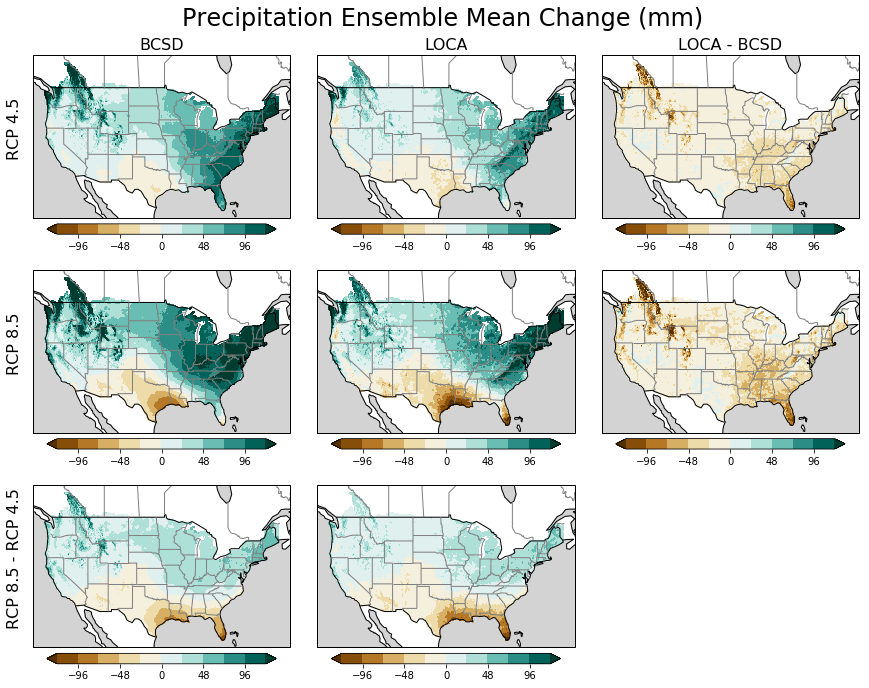

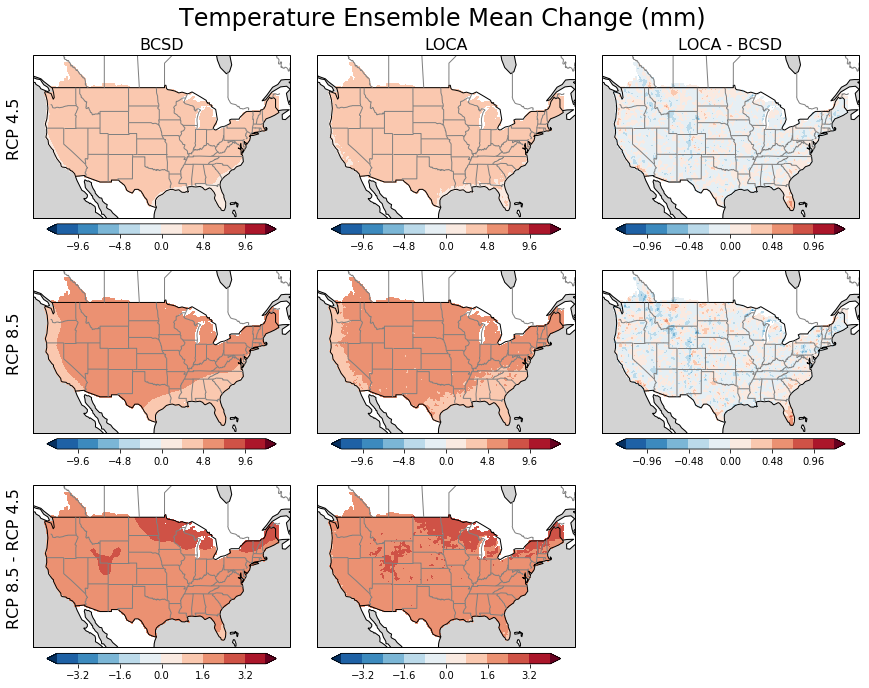

In [22]:
# Figure 9, 10 

cache = {}

style_kwargs =  {'levels': 11, 'add_labels': False, 'extend': 'both', 'cbar_kwargs': dict(orientation="horizontal", shrink=0.85, pad=0.03)}

subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)] 
met_vars = ['pcp', 't_mean']

nrows = 1 + 2

watercmap = cm.rain  #https://matplotlib.org/cmocean/
watercmapdiff = 'BrBG'
tempcmapdiff = 'RdBu_r'


diff_kws = {False: {'pcp': {'vmin': -120, 'vmax': 120, 'cmap': watercmapdiff, **style_kwargs}, 
                    't_mean': {'vmin': -12, 'vmax': 12, 'cmap': tempcmapdiff,**style_kwargs}},
            True: {'pcp': {'vmin': -25, 'vmax': 25, 'cmap': watercmapdiff, **style_kwargs}}}

diff2_kws = {False: {'pcp': {'vmin': -120, 'vmax': 120, 'cmap': watercmapdiff, **style_kwargs}, 
                     't_mean': {'vmin': -4, 'vmax': 4, 'cmap': tempcmapdiff, **style_kwargs}},
             True: {'pcp': {'vmin': -15, 'vmax': 15, 'cmap': watercmapdiff, **style_kwargs}}}

diff3_kws = {False: {'pcp': {'vmin': -120, 'vmax': 120, 'cmap': watercmapdiff, **style_kwargs}, 
                     't_mean': {'vmin': -1.2, 'vmax': 1.2, 'cmap': tempcmapdiff, **style_kwargs}},
             True: {'pcp': {'vmin': -15, 'vmax': 15, 'cmap': watercmapdiff, **style_kwargs}}}

for pct in [False]:

    for var in met_vars:
        if var not in diff_kws[pct]:
            continue
        fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 3.1*nrows), subplot_kw={'projection': PROJECTION})

        for row, (title, dsets) in enumerate(subcols[1:]):

            for col, dset in enumerate(['bcsd', 'loca']):
                ax = axes[row, col]
                ens_change = calc_change(hist_means[dset][var].mean('gcm'), dsets[dset][var].mean('gcm'), pct=pct)
                make_plot(ens_change, ax=ax, plot_kwargs=diff_kws[pct][var]) 
                cache[(row, col)] = ens_change.persist()

                if row == 0:
                    ax.set_title(dset.upper(),  fontsize=16)
                if col == 0:
                    add_ylabel(ax, title, fontsize=16)

            diff = cache[(row, col)] - cache[(row, col - 1)]
            make_plot(diff, ax=axes[row, col + 1], plot_kwargs=diff3_kws[pct][var])
            axes[0, -1].set_title('LOCA - BCSD', fontsize=16)

        for col in [0, 1]:
            diff2 = cache[(row, col)] - cache[(row - 1, col)]
            make_plot(diff2, ax=axes[row + 1, col], plot_kwargs=diff2_kws[pct][var])
        add_ylabel(axes[-1, 0], 'RCP 8.5 - RCP 4.5', fontsize=16)  
    
        fig.delaxes(axes[-1, -1])

        if pct:
            unit_str = '%'
        else:
            unit_str = 'mm'
        variablename = {'t_mean':'Temperature', 'pcp': 'Precipitation'}
        title = variablename[var] + " Ensemble Mean Change (%s) " % unit_str
#         title = var.upper() + " Ensemble Mean Change (%s) " % unit_str
        unit_str = unit_str.replace('%', 'pct')
        fig.suptitle(title, fontsize=24, y=1.03)
        fig.tight_layout()
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/change_signal_{var}_{unit_str}_mon_fut_met.png', dpi=300, bbox_inches='tight')

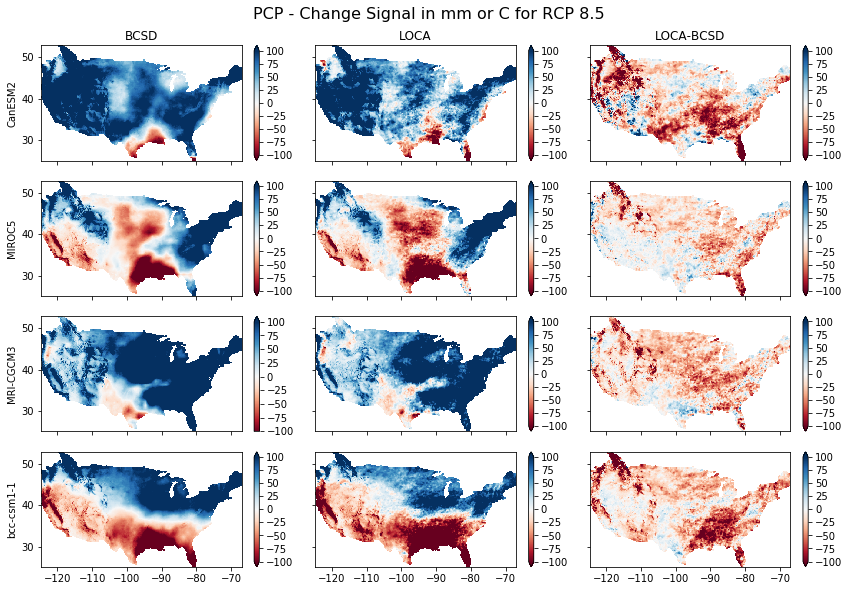

In [10]:
#FOR APPENDIX (not yet revised)
# Plot of change signal with BCSD, LOCA, and LOCA-BCSD


# models = ['ACCESS1-0', 'CanESM2','MIROC5', 'MRI-CGCM3','bcc-csm1-1'] #current 5
models = ['CanESM2','MIROC5', 'MRI-CGCM3','bcc-csm1-1'] #current 5
gcmnum = 'gcm5'  #TODO GET GCM NUMBER IN TITLE

# met_vars = ['pcp', 't_mean']

met_vars = ['pcp']

# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4',
#           'CESM1-BGC', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
#           'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
#           'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']
# gcmnum = 'gcm25'

# subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)] 
# Note: historical should give zeros

subcols = [('RCP 8.5', rpc8_means)]
# subcols = [('RCP 4.5', rpc4_means)]

cache = {}

diff_kws = {False: {'pcp': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu'}, 't_mean': {'vmin': -10, 'vmax': 10, 'cmap': 'RdBu_r'}},
            True: {'pcp': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu'}}}
diff2_kws = {False: {'pcp': {'vmin': -75, 'vmax': 75, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}},
             True: {'pcp': {'vmin': -15, 'vmax': 15, 'cmap': 'RdBu'}}}

# for pct in [True, False]:
for pct in [False]:
    for var in met_vars:

        
        if var not in diff_kws[pct]:
            continue

        fig, axes = plt.subplots(ncols=3, nrows=len(models), sharex=True, sharey=True, figsize=(12, 2*len(models)))

        for row, model in enumerate(models):
            
            for col, (rcp, ds_dict) in enumerate(subcols[0:]):             

                bcsd_diff = calc_change(hist_means['bcsd'][var].sel(gcm=model), ds_dict['bcsd'][var].sel(gcm=model), pct=pct)
                loca_diff = calc_change(hist_means['loca'][var].sel(gcm=model), ds_dict['loca'][var].sel(gcm=model), pct=pct)

                ax = axes[row, 0]
                bcsd_diff.plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
                if row == 0:
                    ax.set_title('BCSD')
                ax.set_ylabel(model)
                
                ax = axes[row, 1]
                loca_diff.plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
                if row == 0:
                    ax.set_title('LOCA')
#                     ax.set_title(rcp)
                
                ax = axes[row, 2]
                (loca_diff - bcsd_diff).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
                if row == 0:
                    ax.set_title('LOCA-BCSD')
        
        if pct:
            title = var.upper() + " - difference (%) in Change Signal)"
            unit_str = 'pct'
        else:
            unit_str = 'unit'
            title = var.upper() +  " - Change Signal in mm or C for %s" %rcp  #change so ok for T
        fig.suptitle(title, fontsize=16, y=1.02)
        fig.tight_layout() 
#         fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{gcmnum}_diff2_{var}_{unit_str}_{rcp}_mon_future_met_change.png', dpi=300, bbox_inches='tight')
       

In [ ]:
xr.open_mfdataset('/glade/u/home/jvano/scratch/not_working/monthly_cmip_met_hist.bcsd_MIROC-ESM-CHEM.nc')

In [ ]:
plt.close('all')